In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
# Load the data
eur_regression_df = pd.read_csv('eur_regression_dataW8.csv')

In [ ]:
# Run OLS, Lasso (and then OLS) and random forest (and then OLS) for each (start, tenor) combination, on the same train/test split

macro_features = ['value_rate', '5y5y_inflation_swap','balance_sheet' ,'10y_swap_spread', '3m3m_1y3m_curve_slope']
combinations = eur_regression_df[['start_months', 'tenor_months']].drop_duplicates()
results_all = []

for _, row in combinations.iterrows():
    start = row['start_months']
    tenor = row['tenor_months']
    df_sub = eur_regression_df[(eur_regression_df['start_months'] == start) & (eur_regression_df['tenor_months'] == tenor)]
    df_sub = df_sub.dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- OLS on all features (baseline) using the train/test split ---
    ols_all = LinearRegression()
    ols_all.fit(X_train, y_train)
    y_train_pred = ols_all.predict(X_train)
    y_test_pred = ols_all.predict(X_test)
    coefs = ols_all.coef_

    # performance (train & test)
    n_train = len(y_train)
    n_test = len(y_test)
    p_all = X_train.shape[1]

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_all - 1) if n_train > p_all + 1 else np.nan
    adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_all - 1) if n_test > p_all + 1 else np.nan

    # t-stats / p-values on train set (statsmodels)
    X_train_sm = sm.add_constant(X_train)
    sm_ols = sm.OLS(y_train, X_train_sm).fit()
    t_stats = sm_ols.tvalues[1:]  # exclude const
    p_values = sm_ols.pvalues[1:]

    # --- Lasso feature selection on same train set, then OLS refit on selected features ---
    lasso_pipe = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=10000))
    lasso_pipe.fit(X_train, y_train)
    lasso_coefs_raw = lasso_pipe.named_steps['lassocv'].coef_  # aligned with macro_features
    selected = [f for f, c in zip(macro_features, lasso_coefs_raw) if abs(c) > 1e-6]
    lasso_num = len(selected)

    # record lasso raw coefficients per feature
    lasso_coef_dict = {f'lasso_coef_{f}': float(c) for f, c in zip(macro_features, lasso_coefs_raw)}

    # metrics for lasso-refit OLS (use same train/test)
    if selected:
        ols_lasso = LinearRegression()
        ols_lasso.fit(X_train[selected], y_train)
        y_train_pred_lasso = ols_lasso.predict(X_train[selected])
        y_test_pred_lasso = ols_lasso.predict(X_test[selected])

        mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
        mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
        rmse_train_lasso = np.sqrt(mse_train_lasso)
        rmse_test_lasso = np.sqrt(mse_test_lasso)
        r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
        r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

        p_lasso = len(selected)
        adj_r2_train_lasso = 1 - (1 - r2_train_lasso) * (n_train - 1) / (n_train - p_lasso - 1) if n_train > p_lasso + 1 else np.nan
        adj_r2_test_lasso = 1 - (1 - r2_test_lasso) * (n_test - 1) / (n_test - p_lasso - 1) if n_test > p_lasso + 1 else np.nan
    else:
        mse_train_lasso = mse_test_lasso = rmse_train_lasso = rmse_test_lasso = np.nan
        r2_train_lasso = r2_test_lasso = adj_r2_train_lasso = adj_r2_test_lasso = np.nan

    # --- Random Forest feature importances on the same train/test split ---
    rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_importances = rf_model.feature_importances_  # aligned with macro_features
    rf_imp_dict = {f'rf_imp_{f}': float(imp) for f, imp in zip(macro_features, rf_importances)}
    rf_selected = [f for f, imp in zip(macro_features, rf_importances) if imp >= 0.01]
    rf_num_selected = len(rf_selected)

    # Refit OLS using only RF-selected features (drop features with importance < 0.01)
    if rf_selected:
        ols_rfsel = LinearRegression()
        ols_rfsel.fit(X_train[rf_selected], y_train)
        y_test_pred_rfsel = ols_rfsel.predict(X_test[rf_selected])
        mse_test_rfsel = mean_squared_error(y_test, y_test_pred_rfsel)
        rmse_test_rfsel = np.sqrt(mse_test_rfsel)
        r2_test_rfsel = r2_score(y_test, y_test_pred_rfsel)

        p_rfsel = len(rf_selected)
        adj_r2_test_rfsel = 1 - (1 - r2_test_rfsel) * (n_test - 1) / (n_test - p_rfsel - 1) if n_test > p_rfsel + 1 else np.nan
    else:
        mse_test_rfsel = rmse_test_rfsel = r2_test_rfsel = adj_r2_test_rfsel = np.nan

    results_all.append({
        'start_months': start,
        'tenor_months': tenor,
        # OLS (all) coefficients
        **{f: float(c) for f, c in zip(macro_features, coefs)},
        # t-stats / p-values (train)
        **{f'tstat_{f}': float(t) for f, t in zip(macro_features, t_stats)},
        **{f'pval_{f}': float(p) for f, p in zip(macro_features, p_values)},
        # baseline performance (train & test)
        'MSE_train': float(mse_train),
        'MSE_test': float(mse_test),
        'RMSE_test': float(rmse_test),
        'R2_test': float(r2_test),
        'Adj_R2_test': float(adj_r2_test) if not np.isnan(adj_r2_test) else np.nan,
        # Lasso summary
        'lasso_num_selected': int(lasso_num),
        'lasso_selected_features': selected,
        **lasso_coef_dict,
        # Lasso -> OLS performance (train & test)
        'MSE_train_lasso': float(mse_train_lasso) if not np.isnan(mse_train_lasso) else np.nan,
        'MSE_test_lasso': float(mse_test_lasso) if not np.isnan(mse_test_lasso) else np.nan,
        'RMSE_test_lasso': float(rmse_test_lasso) if not np.isnan(rmse_test_lasso) else np.nan,
        'R2_test_lasso': float(r2_test_lasso) if not np.isnan(r2_test_lasso) else np.nan,
        'Adj_R2_test_lasso': float(adj_r2_test_lasso) if not np.isnan(adj_r2_test_lasso) else np.nan,
        'n_obs': len(df_sub),
        # Random Forest importances + RF-based OLS refit (same train/test)
        **rf_imp_dict,
        'rf_num_selected': int(rf_num_selected),
        'rf_selected_features': rf_selected,
        'MSE_test_rfsel': float(mse_test_rfsel) if not np.isnan(mse_test_rfsel) else np.nan,
        'RMSE_test_rfsel': float(rmse_test_rfsel) if not np.isnan(rmse_test_rfsel) else np.nan,
        'R2_test_rfsel': float(r2_test_rfsel) if not np.isnan(r2_test_rfsel) else np.nan,
        'Adj_R2_test_rfsel': float(adj_r2_test_rfsel) if not np.isnan(adj_r2_test_rfsel) else np.nan,
    })

df_all = pd.DataFrame(results_all)
df_all.to_csv('W10_eur_regression_results.csv', index=False)
df_all.head()

,start_months,tenor_months,value_rate,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope,tstat_value_rate,tstat_5y5y_inflation_swap,tstat_balance_sheet,...,rf_imp_5y5y_inflation_swap,rf_imp_balance_sheet,rf_imp_10y_swap_spread,rf_imp_3m3m_1y3m_curve_slope,rf_num_selected,rf_selected_features,MSE_test_rfsel,RMSE_test_rfsel,R2_test_rfsel,Adj_R2_test_rfsel
0,3,12,-2.070630,-3.866201,0.001119,-0.016579,0.126813,-28.563058,-16.027160,38.892704,...,0.052890,0.457658,0.048604,0.069585,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.889053,0.942896,0.874741,0.872110
1,3,24,-1.648624,-1.265994,0.000920,-0.019574,0.391641,-21.267665,-5.037673,32.693657,...,0.024135,0.702080,0.106560,0.037057,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.987370,0.993665,0.802358,0.798374
2,3,36,-1.091831,0.840290,0.000635,-0.007541,1.313560,-12.971259,3.268078,22.454994,...,0.025434,0.763230,0.081861,0.015090,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.268208,1.126147,0.596611,0.589888
3,3,60,-0.647249,1.544229,0.000282,-0.007372,1.680369,-8.768649,7.782571,13.181868,...,0.020658,0.735198,0.080806,0.078377,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.949207,0.974272,0.570383,0.564958
4,3,84,-0.466224,0.771211,0.000111,-0.013106,1.544450,-7.840237,5.024452,7.081468,...,0.021768,0.684941,0.065726,0.188712,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.785187,0.886108,0.572513,0.567531
5,3,120,-0.579052,0.217341,0.000014,-0.017202,1.208104,-11.872351,1.692611,1.263593,...,0.012803,0.324360,0.048705,0.462703,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.680260,0.824779,0.538456,0.533668
6,3,360,-1.624852,1.333525,-0.000046,-0.025775,0.442844,-20.900805,7.878550,-2.565566,...,0.014050,0.523649,0.058181,0.022593,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.162087,1.078001,0.466090,0.460966
7,6,12,-2.021594,-2.178872,0.001047,-0.016574,-0.150803,-33.894076,-10.333837,44.523301,...,0.021301,0.593120,0.077381,0.019117,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.868865,0.932130,0.787883,0.783408
8,6,24,-1.630305,-0.205054,0.000866,-0.015679,0.192740,-24.286502,-0.958574,35.852561,...,0.025714,0.742749,0.092914,0.019591,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.776198,0.881021,0.781235,0.776860
9,6,36,-1.105355,1.737548,0.000564,-0.004721,1.023720,-13.856460,7.367709,21.809555,...,0.021899,0.761415,0.082417,0.016034,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.991492,0.995737,0.602791,0.596487


In [ ]:
# Compute and compare mean test R2 for OLS, Lasso->OLS and RF->OLS
rf_col = 'R2_test_rfsel' if 'R2_test_rfsel' in df_all.columns else ('R2_test_rf' if 'R2_test_rf' in df_all.columns else None)

mean_ols = df_all['R2_test'].mean() if 'R2_test' in df_all.columns else np.nan
mean_lasso = df_all['R2_test_lasso'].mean() if 'R2_test_lasso' in df_all.columns else np.nan
mean_rf = df_all[rf_col].mean() if rf_col is not None else np.nan

print(f"Mean R2_test (OLS)        : {mean_ols:.4f}")
print(f"Mean R2_test (Lasso->OLS) : {mean_lasso:.4f}")
print(f"Mean R2_test (RF->OLS)    : {mean_rf:.4f}")

pd.DataFrame({
    'model': ['OLS', 'Lasso->OLS', 'RF->OLS'],
    'mean_R2_test': [mean_ols, mean_lasso, mean_rf]
})


Mean R2_test (OLS)        : 0.6653
Mean R2_test (Lasso->OLS) : 0.6653
Mean R2_test (RF->OLS)    : 0.6600


,model,mean_R2_test
0,OLS,0.665273
1,Lasso->OLS,0.665273
2,RF->OLS,0.660003


In [5]:
adj_rf_col = 'Adj_R2_test_rfsel' if 'Adj_R2_test_rfsel' in df_all.columns else ('Adj_R2_test_rf' if 'Adj_R2_test_rf' in df_all.columns else None)

mean_adj_ols = df_all['Adj_R2_test'].mean() if 'Adj_R2_test' in df_all.columns else np.nan
mean_adj_lasso = df_all['Adj_R2_test_lasso'].mean() if 'Adj_R2_test_lasso' in df_all.columns else np.nan
mean_adj_rf = df_all[adj_rf_col].mean() if adj_rf_col is not None else np.nan

print(f"Mean Adj_R2_test (OLS)        : {mean_adj_ols:.4f}")
print(f"Mean Adj_R2_test (Lasso->OLS) : {mean_adj_lasso:.4f}")
print(f"Mean Adj_R2_test (RF->OLS)    : {mean_adj_rf:.4f}")

pd.DataFrame({
    'model': ['OLS', 'Lasso->OLS', 'RF->OLS'],
    'mean_Adj_R2_test': [mean_adj_ols, mean_adj_lasso, mean_adj_rf]
})

Mean Adj_R2_test (OLS)        : 0.6610
Mean Adj_R2_test (Lasso->OLS) : 0.6610
Mean Adj_R2_test (RF->OLS)    : 0.6559


,model,mean_Adj_R2_test
0,OLS,0.661024
1,Lasso->OLS,0.661024
2,RF->OLS,0.655861


In [ ]:
# Show mean R2_test for OLS, Lasso->OLS and RF->OLS (robust to column name variations)
def find_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

model_cols = {
    'OLS': ['R2_test'],
    'Lasso->OLS': ['R2_test_lasso', 'R2_test_lasso'],  # keep candidates for safety
    'RF->OLS': ['R2_test_rfsel', 'R2_test_rf', 'R2_test_rfsel']
}

def mean_r2_summary(df, df_name):
    rows = []
    for model, candidates in model_cols.items():
        col = find_column(df, candidates)
        if col is None:
            rows.append({'model': model, 'col_used': None, 'mean_R2_test': np.nan, 'n_nonmissing': 0})
            continue
        mean_val = float(df[col].mean())
        n = int(df[col].notna().sum())
        rows.append({'model': model, 'col_used': col, 'mean_R2_test': mean_val, 'n_nonmissing': n})
    out = pd.DataFrame(rows)
    print(f"{df_name} — mean R2_test by model")
    print(out[['model','col_used','mean_R2_test','n_nonmissing']])
    return out

# apply to df_all and df_refit (if present)
summ_all = mean_r2_summary(df_all, 'df_all') if 'df_all' in globals() else None
summ_refit = mean_r2_summary(df_refit, 'df_refit') if 'df_refit' in globals() else None

combined = pd.concat([summ_all.assign(dataset='df_all') if summ_all is not None else pd.DataFrame(),
                      summ_refit.assign(dataset='df_refit') if summ_refit is not None else pd.DataFrame()],
                     ignore_index=True)
combined

df_all — mean R2_test by model
        model       col_used  mean_R2_test  n_nonmissing
0         OLS        R2_test      0.665273            42
1  Lasso->OLS  R2_test_lasso      0.665273            42
2     RF->OLS  R2_test_rfsel      0.660003            42


,model,col_used,mean_R2_test,n_nonmissing,dataset
0,OLS,R2_test,0.665273,42,df_all
1,Lasso->OLS,R2_test_lasso,0.665273,42,df_all
2,RF->OLS,R2_test_rfsel,0.660003,42,df_all


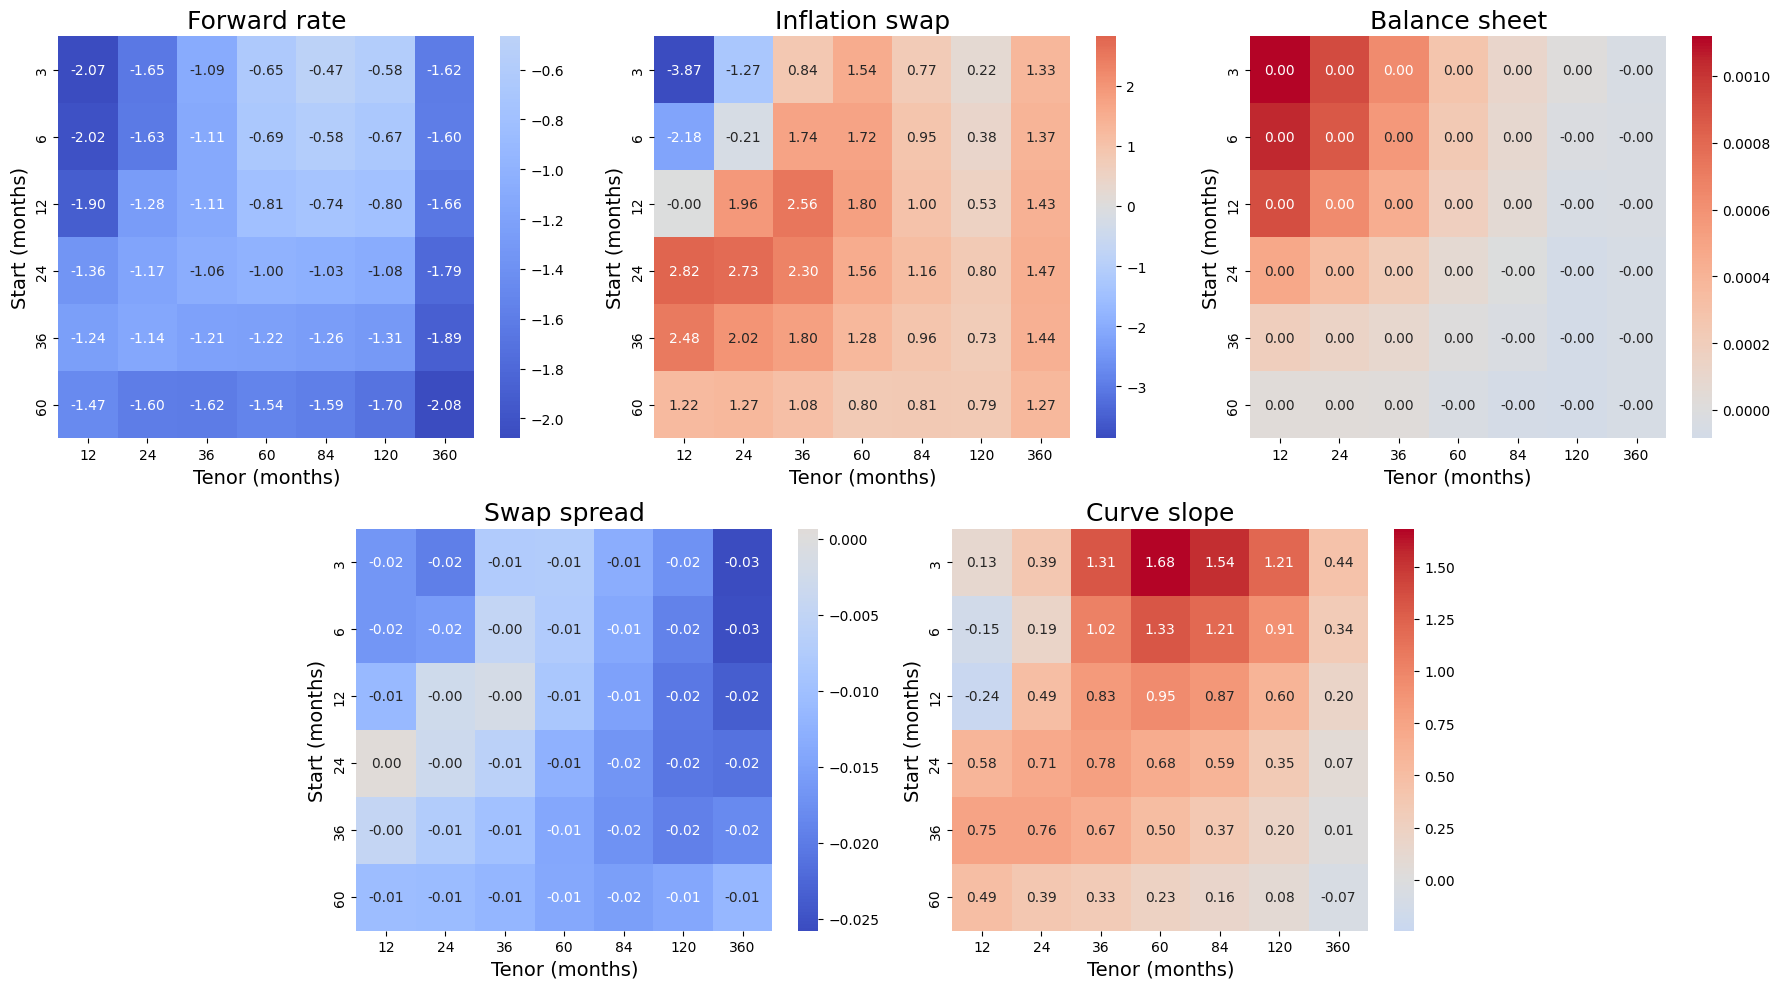

In [ ]:
# Pretty labels for plotting
label_map = {
    'value_rate': 'Forward rate',
    '5y5y_inflation_swap': 'Inflation swap',
    'balance_sheet': 'Balance sheet',
    '10y_swap_spread': 'Swap spread',
    '3m3m_1y3m_curve_slope': 'Curve slope'
}

# Create pivot tables for each macro feature
pivot_tables = []
for feature in macro_features:
    pivot = df_all.pivot(index='start_months', columns='tenor_months', values=feature)
    pivot_tables.append(pivot)

fig = plt.figure(figsize=(18, 10))
# Create a 2-row × 6-column grid to allow horizontal shifting
gs = fig.add_gridspec(2, 6)

# First row (keep as is)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

# Second row (shifted to be between top plots)
ax4 = fig.add_subplot(gs[1, 1:3])  # between ax1 and ax2
ax5 = fig.add_subplot(gs[1, 3:5])  # between ax2 and ax3

axes = [ax1, ax2, ax3, ax4, ax5]

# Plot heatmaps
for ax, (feature, pivot) in zip(axes, zip(macro_features, pivot_tables)):
    sns.heatmap(
        pivot, ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".2f",
        cbar=True, vmin=np.nanmin(pivot.values), vmax=np.nanmax(pivot.values)
    )
    ax.set_title(label_map[feature], fontsize=18)  # use pretty names
    ax.set_xlabel('Tenor (months)', fontsize=14)
    ax.set_ylabel('Start (months)', fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
# Filter data for 2021-2024 before running the regression

eur_regression_df['date'] = pd.to_datetime(eur_regression_df['date'])
df_2020_2024 = eur_regression_df[(eur_regression_df['date'] >= '2022-01-01') & (eur_regression_df['date'] <= '2025-11-01')]

macro_features = ['value_rate', '5y5y_inflation_swap','balance_sheet' ,'10y_swap_spread', '3m3m_1y3m_curve_slope']
combinations = df_2020_2024[['start_months', 'tenor_months']].drop_duplicates()
results_all = []

for _, row in combinations.iterrows():
    start = row['start_months']
    tenor = row['tenor_months']
    df_sub = df_2020_2024[(df_2020_2024['start_months'] == start) & (df_2020_2024['tenor_months'] == tenor)]
    df_sub = df_sub.dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        continue
    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    ols_all = LinearRegression()
    ols_all.fit(X_train, y_train)
    y_train_pred = ols_all.predict(X_train)
    y_test_pred = ols_all.predict(X_test)
    coefs = ols_all.coef_
# Calculate adjusted R2 for train and test
    n_train = len(y_train)
    n_test = len(y_test)
    p = X_train.shape[1]
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1) if n_train > p + 1 else np.nan
    adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1) if n_test > p + 1 else np.nan

    # RMSE for train and test
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results_all.append({
        'start_months': start,
        'tenor_months': tenor,
        **{f: c for f, c in zip(macro_features, coefs)},
        'MSE_train': mean_squared_error(y_train, y_train_pred),
        'MSE_test': mean_squared_error(y_test, y_test_pred),
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'Adj_R2_train': adj_r2_train,
        'Adj_R2_test': adj_r2_test,
        'n_obs': len(df_sub)
    })

df_all_22 = pd.DataFrame(results_all)
df_all_22.head()

,start_months,tenor_months,value_rate,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope,MSE_train,MSE_test,RMSE_train,RMSE_test,R2_train,R2_test,Adj_R2_train,Adj_R2_test,n_obs
0,3,84,-0.362851,-4.630296,-0.000069,-0.046799,0.858538,0.579222,0.535751,0.761066,0.731950,0.857298,0.839601,0.856229,0.834681,843
1,3,120,-0.216531,-3.698641,0.000518,-0.027766,0.433644,0.378691,0.369344,0.615379,0.607737,0.873922,0.858521,0.872978,0.854181,843
2,3,360,-0.407907,-2.103135,0.000765,-0.015658,0.400685,0.340583,0.363215,0.583595,0.602673,0.874255,0.865406,0.873314,0.861277,843
3,6,84,-0.459808,-3.696277,0.000044,-0.040311,0.523822,0.419287,0.385446,0.647523,0.620843,0.859578,0.846579,0.858527,0.841872,843
4,6,120,-0.354261,-2.969444,0.000565,-0.023767,0.169167,0.282225,0.274567,0.531248,0.523992,0.877939,0.865613,0.877025,0.861490,843
5,6,360,-0.465455,-1.816954,0.000812,-0.013593,0.209584,0.294924,0.325927,0.543070,0.570900,0.874138,0.861388,0.873196,0.857136,843
6,12,84,-0.622656,-2.470690,0.000229,-0.031150,0.180678,0.266999,0.243877,0.516720,0.493839,0.871611,0.864947,0.870650,0.860805,843
7,12,120,-0.528793,-2.055512,0.000653,-0.018331,-0.101250,0.195035,0.184547,0.441628,0.429590,0.886876,0.880482,0.886029,0.876816,843
8,12,360,-0.596451,-1.379324,0.000761,-0.012617,0.076936,0.246903,0.260711,0.496893,0.510598,0.874681,0.866902,0.873743,0.862819,843
9,24,84,-0.898638,-1.122377,0.000362,-0.021561,-0.001966,0.151579,0.138085,0.389331,0.371597,0.900341,0.901960,0.899595,0.898953,843


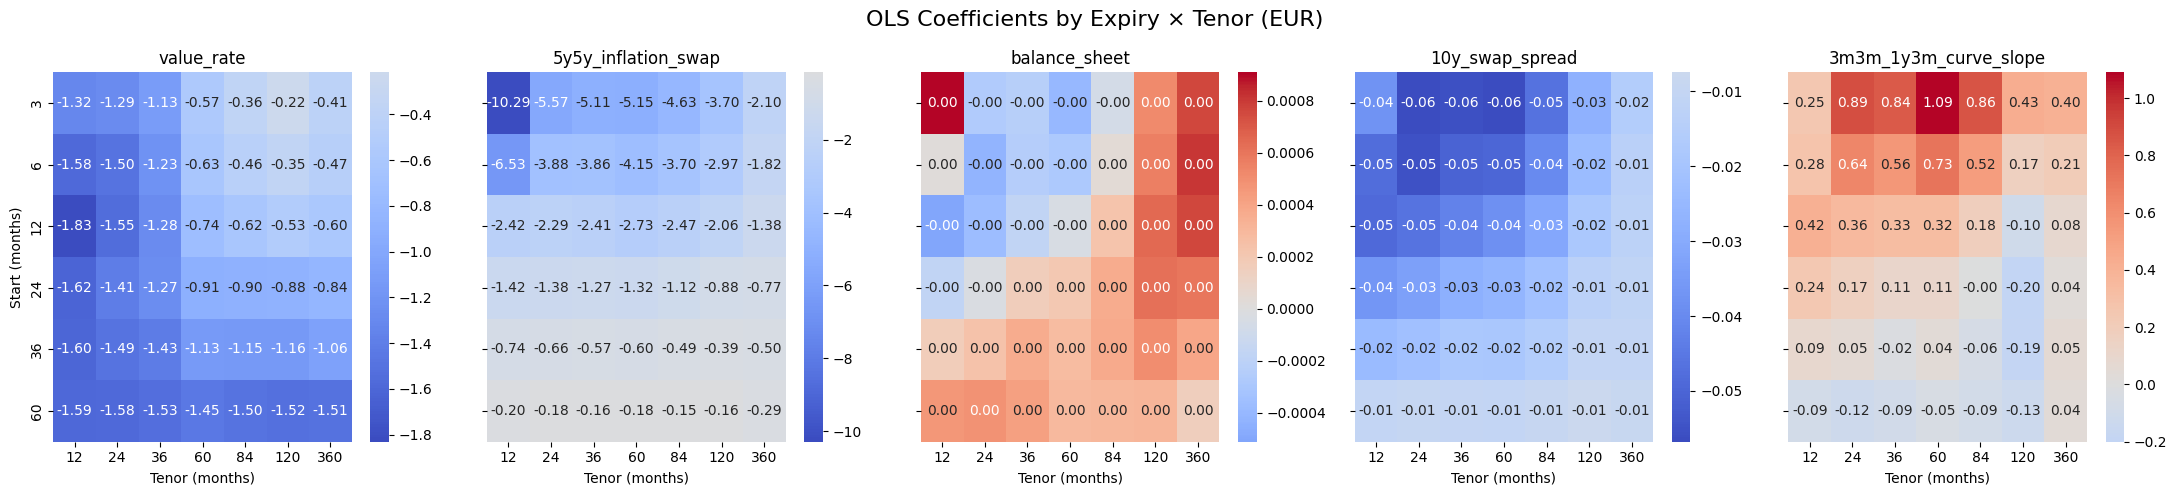

In [ ]:
# Create pivot tables for each macro feature, check if Filter data 2021-2024 has similar coefficients 
pivot_tables = []
for feature in macro_features:
    pivot = df_all_22.pivot(index='start_months', columns='tenor_months', values=feature)
    pivot_tables.append(pivot)

fig, axes = plt.subplots(1, 5, figsize=(22, 5), sharey=True)
for i, (feature, pivot) in enumerate(zip(macro_features, pivot_tables)):
    # Use independent color scale for each heatmap
    sns.heatmap(
        pivot, ax=axes[i], cmap='coolwarm', center=0, annot=True, fmt=".2f",
        cbar=True, vmin=np.nanmin(pivot.values), vmax=np.nanmax(pivot.values)
    )
    axes[i].set_title(feature)
    axes[i].set_xlabel('Tenor (months)')
    if i == 0:
        axes[i].set_ylabel('Start (months)')
    else:
        axes[i].set_ylabel('')
fig.suptitle('OLS Coefficients by Expiry × Tenor (EUR)', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
def print_mean_r2(df, name):
    if df is None or 'R2_test' not in df.columns:
        print(f"{name}: R2_test not available")
        return
    mean_r2 = np.nanmean(df['R2_test'])
    n = df['R2_test'].notna().sum()
    print(f"{name} — mean R2_test: {mean_r2:.4f}  (n={n})")

print_mean_r2(df_all if 'df_all' in globals() else None, 'df_all')
print_mean_r2(df_all_22 if 'df_all_22' in globals() else None, 'df_all_22')

# Optional: mean of adjusted R2
def print_mean_adj_r2(df, name):
    if df is None or 'Adj_R2_test' not in df.columns:
        print(f"{name}: Adj_R2_test not available")
        return
    mean_adj = np.nanmean(df['Adj_R2_test'])
    n = df['Adj_R2_test'].notna().sum()
    print(f"{name} — mean Adj_R2_test: {mean_adj:.4f}  (n={n})")

print_mean_adj_r2(df_all if 'df_all' in globals() else None, 'df_all')
print_mean_adj_r2(df_all_22 if 'df_all_22' in globals() else None, 'df_all_22')

df_all — mean R2_test: 0.6653  (n=42)
df_all_22 — mean R2_test: 0.8841  (n=42)
df_all — mean Adj_R2_test: 0.6610  (n=42)
df_all_22 — mean Adj_R2_test: 0.8805  (n=42)


# Leave one feature out     

In [ ]:
# Refit OLS using only features that *decrease* MSE (i.e. removing them increases test MSE -> LOFO > 0)
macro_features = ['value_rate', '5y5y_inflation_swap', 'balance_sheet', '10y_swap_spread', '3m3m_1y3m_curve_slope']
combinations = eur_regression_df[['start_months', 'tenor_months']].drop_duplicates().values.tolist()

results_refit = []
for start, tenor in combinations:
    df_sub = eur_regression_df.query("start_months == @start and tenor_months == @tenor").dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # baseline test error with all features
    base_model = LinearRegression().fit(X_train, y_train)
    y_pred_base = base_model.predict(X_test)
    mse_base = mean_squared_error(y_test, y_pred_base)

    # LOFO: compute ΔMSE = MSE_without_feature - MSE_with_all
    lofo_scores = {}
    for f in macro_features:
        X_train_lofo = X_train.drop(columns=[f])
        X_test_lofo = X_test.drop(columns=[f])
        m_lofo = LinearRegression().fit(X_train_lofo, y_train)
        y_pred_lofo = m_lofo.predict(X_test_lofo)
        e_lofo = mean_squared_error(y_test, y_pred_lofo)
        lofo_scores[f] = e_lofo - mse_base

    # select features that decrease MSE when present (lofo > 0)
    selected = [f for f, delta in lofo_scores.items() if delta > 0]
    n_selected = len(selected)

    if n_selected == 0:
        # record that no feature reduced MSE
        results_refit.append({
            'start_months': start,
            'tenor_months': tenor,
            'selected_features': [],
            'n_selected': 0,
            'R2_test_refit': np.nan,
            'Adj_R2_test_refit': np.nan,
            'MSE_test_refit': np.nan,
            'RMSE_test_refit': np.nan,
            **{f'lofo_{f}': float(lofo_scores[f]) for f in macro_features}
        })
        continue

    # Refit OLS on selected features and compute out-of-sample metrics
    ols_sel = LinearRegression().fit(X_train[selected], y_train)
    y_test_pred_sel = ols_sel.predict(X_test[selected])

    mse_test_sel = mean_squared_error(y_test, y_test_pred_sel)
    rmse_test_sel = np.sqrt(mse_test_sel)
    r2_test_sel = r2_score(y_test, y_test_pred_sel)

    n_test = len(y_test)
    p = len(selected)
    adj_r2_test_sel = 1 - (1 - r2_test_sel) * (n_test - 1) / (n_test - p - 1) if n_test > p + 1 else np.nan

    results_refit.append({
        'start_months': start,
        'tenor_months': tenor,
        'selected_features': selected,
        'n_selected': n_selected,
        'R2_test_refit': float(r2_test_sel),
        'Adj_R2_test_refit': float(adj_r2_test_sel) if not np.isnan(adj_r2_test_sel) else np.nan,
        'MSE_test_refit': float(mse_test_sel),
        'RMSE_test_refit': float(rmse_test_sel),
        **{f'lofo_{f}': float(lofo_scores[f]) for f in macro_features}
    })

df_refit = pd.DataFrame(results_refit)
df_refit.to_csv('W9_eur_ols_refit_lofo.csv', index=False)

# Quick summary
print(f"Refit combos: {len(df_refit)}")
if 'R2_test_refit' in df_refit.columns and df_refit['R2_test_refit'].notna().any():
    print(f"Mean R2_test (refit): {df_refit['R2_test_refit'].mean():.4f}  (n={df_refit['R2_test_refit'].notna().sum()})")
    display(df_refit.sort_values('R2_test_refit', ascending=False).head(10))
else:
    print("No successful refits (no features selected for any combination).")


Refit combos: 42
Mean R2_test (refit): 0.6654  (n=42)


,start_months,tenor_months,selected_features,n_selected,R2_test_refit,Adj_R2_test_refit,MSE_test_refit,RMSE_test_refit,lofo_value_rate,lofo_5y5y_inflation_swap,lofo_balance_sheet,lofo_10y_swap_spread,lofo_3m3m_1y3m_curve_slope
0,3,12,"[value_rate, 5y5y_inflation_swap, balance_shee...",4,0.875936,0.873859,0.880574,0.938389,1.034183,0.140882,1.833992,0.109798,-0.008479
36,60,24,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.864422,0.862804,0.144612,0.380279,0.152631,0.003004,0.001978,0.033206,0.018198
38,60,60,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.860924,0.859403,0.172685,0.415554,0.220526,0.005587,0.004426,0.042475,0.008994
37,60,36,"[value_rate, 5y5y_inflation_swap, 10y_swap_spr...",4,0.855583,0.854243,0.162490,0.403100,0.187353,0.015576,-0.001461,0.032908,0.014328
40,60,120,"[value_rate, 5y5y_inflation_swap, balance_shee...",4,0.853352,0.852172,0.209239,0.457427,0.280912,0.007656,0.015494,0.054421,-0.000398
39,60,84,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.849039,0.847467,0.194855,0.441424,0.241683,0.003371,0.007467,0.051228,0.004083
35,60,12,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.838687,0.836710,0.180235,0.424541,0.229192,0.034130,0.001478,0.019507,0.023608
14,12,12,"[value_rate, 5y5y_inflation_swap, balance_shee...",4,0.822473,0.819476,0.491376,0.700982,0.562342,0.000038,1.073969,0.036305,-0.000938
1,3,24,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.802358,0.798374,0.987370,0.993665,0.473431,0.014733,1.277803,0.099652,0.021099
31,36,60,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.792825,0.790404,0.179906,0.424153,0.100532,0.016774,0.000170,0.038314,0.030104


In [ ]:
# Compute mean R2_test across combinations
for df_name, col in [('df_all', 'R2_test'), ('df_refit', 'R2_test_refit')]:
    if df_name in globals():
        df = globals()[df_name]
        if col in df.columns:
            n_nonnull = int(df[col].notna().sum())
            mean_r2 = float(df[col].mean()) if n_nonnull > 0 else np.nan
            print(f"{df_name}: mean {col} = {mean_r2:.4f} (non-missing = {n_nonnull}, total rows = {len(df)})")
        else:
            print(f"{col} not found in {df_name}")
    else:
        print(f"{df_name} not found in workspace")


df_all: mean R2_test = 0.6653 (non-missing = 42, total rows = 42)
df_refit: mean R2_test_refit = 0.6654 (non-missing = 42, total rows = 42)


# Metrics

In [16]:
# Compare LOVO vs baseline

mean_r2_refit = df_refit['R2_test_refit'].mean() # 0.66544
mean_adj_r2_refit = df_refit['Adj_R2_test_refit'].mean() # 0.6613
mean_mse_refit = df_refit['MSE_test_refit'].mean() # 0.5345

mean_r2_base = df_all['R2_test'].mean(), #0.66527
mean_adj_r2_base = df_all['Adj_R2_test'].mean() # 0.66102
mean_mse_base = df_all['MSE_test'].mean() # 0.53509


In [17]:
# Compare Lasso vs baseline

mean_r2_lasso = df_all['R2_test_lasso'].mean() # 0.66527
mean_adj_r2_lasso = df_all['Adj_R2_test_lasso'].mean() # 0.66102
mean_mse_lasso = df_all['MSE_test_lasso'].mean() # 0.53509


In [ ]:
# Compare random forest vs baseline

mean_r2_rf = df_all['R2_test_rfsel'].mean(), #0.64360
mean_adj_r2_rf= df_all['Adj_R2_test_rfsel'].mean() # 0.63985
mean_mse_rf = df_all['MSE_test_rfsel'].mean() # 0.56320

# Time period 2021-2024

In [22]:
# ...existing code...


eur_regression_df['date'] = pd.to_datetime(eur_regression_df['date'])
df_2020_2024 = eur_regression_df[(eur_regression_df['date'] >= '2021-06-01') & (eur_regression_df['date'] <= '2025-11-01')]

macro_features = ['value_rate', '5y5y_inflation_swap','balance_sheet' ,'10y_swap_spread', '3m3m_1y3m_curve_slope']
combinations = df_2020_2024[['start_months', 'tenor_months']].drop_duplicates()
results_all = []

for _, row in combinations.iterrows():
    start = row['start_months']
    tenor = row['tenor_months']
    df_sub = eur_regression_df[(eur_regression_df['start_months'] == start) & (eur_regression_df['tenor_months'] == tenor)]
    df_sub = df_sub.dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- OLS on all features (baseline) using the train/test split ---
    ols_all = LinearRegression()
    ols_all.fit(X_train, y_train)
    y_train_pred = ols_all.predict(X_train)
    y_test_pred = ols_all.predict(X_test)
    coefs = ols_all.coef_

    # performance (train & test)
    n_train = len(y_train)
    n_test = len(y_test)
    p_all = X_train.shape[1]

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_all - 1) if n_train > p_all + 1 else np.nan
    adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_all - 1) if n_test > p_all + 1 else np.nan

    # t-stats / p-values on train set (statsmodels)
    X_train_sm = sm.add_constant(X_train)
    sm_ols = sm.OLS(y_train, X_train_sm).fit()
    t_stats = sm_ols.tvalues[1:]  # exclude const
    p_values = sm_ols.pvalues[1:]

    # --- Lasso feature selection on same train set, then OLS refit on selected features ---
    lasso_pipe = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=10000))
    lasso_pipe.fit(X_train, y_train)
    lasso_coefs_raw = lasso_pipe.named_steps['lassocv'].coef_  # aligned with macro_features
    selected = [f for f, c in zip(macro_features, lasso_coefs_raw) if abs(c) > 1e-6]
    lasso_num = len(selected)

    # record lasso raw coefficients per feature
    lasso_coef_dict = {f'lasso_coef_{f}': float(c) for f, c in zip(macro_features, lasso_coefs_raw)}

    # metrics for lasso-refit OLS (use same train/test)
    if selected:
        ols_lasso = LinearRegression()
        ols_lasso.fit(X_train[selected], y_train)
        y_train_pred_lasso = ols_lasso.predict(X_train[selected])
        y_test_pred_lasso = ols_lasso.predict(X_test[selected])

        mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
        mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
        rmse_train_lasso = np.sqrt(mse_train_lasso)
        rmse_test_lasso = np.sqrt(mse_test_lasso)
        r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
        r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

        p_lasso = len(selected)
        adj_r2_train_lasso = 1 - (1 - r2_train_lasso) * (n_train - 1) / (n_train - p_lasso - 1) if n_train > p_lasso + 1 else np.nan
        adj_r2_test_lasso = 1 - (1 - r2_test_lasso) * (n_test - 1) / (n_test - p_lasso - 1) if n_test > p_lasso + 1 else np.nan
    else:
        mse_train_lasso = mse_test_lasso = rmse_train_lasso = rmse_test_lasso = np.nan
        r2_train_lasso = r2_test_lasso = adj_r2_train_lasso = adj_r2_test_lasso = np.nan

    # --- Random Forest feature importances on the same train/test split ---
    rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_importances = rf_model.feature_importances_  # aligned with macro_features
    rf_imp_dict = {f'rf_imp_{f}': float(imp) for f, imp in zip(macro_features, rf_importances)}
    rf_selected = [f for f, imp in zip(macro_features, rf_importances) if imp >= 0.01]
    rf_num_selected = len(rf_selected)

    # Refit OLS using only RF-selected features (drop features with importance < 0.01)
    if rf_selected:
        ols_rfsel = LinearRegression()
        ols_rfsel.fit(X_train[rf_selected], y_train)
        y_test_pred_rfsel = ols_rfsel.predict(X_test[rf_selected])
        mse_test_rfsel = mean_squared_error(y_test, y_test_pred_rfsel)
        rmse_test_rfsel = np.sqrt(mse_test_rfsel)
        r2_test_rfsel = r2_score(y_test, y_test_pred_rfsel)

        p_rfsel = len(rf_selected)
        adj_r2_test_rfsel = 1 - (1 - r2_test_rfsel) * (n_test - 1) / (n_test - p_rfsel - 1) if n_test > p_rfsel + 1 else np.nan
    else:
        mse_test_rfsel = rmse_test_rfsel = r2_test_rfsel = adj_r2_test_rfsel = np.nan

    results_all.append({
        'start_months': start,
        'tenor_months': tenor,
        # OLS (all) coefficients
        **{f: float(c) for f, c in zip(macro_features, coefs)},
        # t-stats / p-values (train)
        **{f'tstat_{f}': float(t) for f, t in zip(macro_features, t_stats)},
        **{f'pval_{f}': float(p) for f, p in zip(macro_features, p_values)},
        # baseline performance (train & test)
        'MSE_train': float(mse_train),
        'MSE_test': float(mse_test),
        'RMSE_test': float(rmse_test),
        'R2_test': float(r2_test),
        'Adj_R2_test': float(adj_r2_test) if not np.isnan(adj_r2_test) else np.nan,
        # Lasso summary
        'lasso_num_selected': int(lasso_num),
        'lasso_selected_features': selected,
        **lasso_coef_dict,
        # Lasso -> OLS performance (train & test)
        'MSE_train_lasso': float(mse_train_lasso) if not np.isnan(mse_train_lasso) else np.nan,
        'MSE_test_lasso': float(mse_test_lasso) if not np.isnan(mse_test_lasso) else np.nan,
        'RMSE_test_lasso': float(rmse_test_lasso) if not np.isnan(rmse_test_lasso) else np.nan,
        'R2_test_lasso': float(r2_test_lasso) if not np.isnan(r2_test_lasso) else np.nan,
        'Adj_R2_test_lasso': float(adj_r2_test_lasso) if not np.isnan(adj_r2_test_lasso) else np.nan,
        'n_obs': len(df_sub),
        # Random Forest importances + RF-based OLS refit (same train/test)
        **rf_imp_dict,
        'rf_num_selected': int(rf_num_selected),
        'rf_selected_features': rf_selected,
        'MSE_test_rfsel': float(mse_test_rfsel) if not np.isnan(mse_test_rfsel) else np.nan,
        'RMSE_test_rfsel': float(rmse_test_rfsel) if not np.isnan(rmse_test_rfsel) else np.nan,
        'R2_test_rfsel': float(r2_test_rfsel) if not np.isnan(r2_test_rfsel) else np.nan,
        'Adj_R2_test_rfsel': float(adj_r2_test_rfsel) if not np.isnan(adj_r2_test_rfsel) else np.nan,
    })

df_all = pd.DataFrame(results_all)
df_all.to_csv('W10_22_eur_regression_results.csv', index=False)
df_all.head(42)

,start_months,tenor_months,value_rate,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope,tstat_value_rate,tstat_5y5y_inflation_swap,tstat_balance_sheet,...,rf_imp_5y5y_inflation_swap,rf_imp_balance_sheet,rf_imp_10y_swap_spread,rf_imp_3m3m_1y3m_curve_slope,rf_num_selected,rf_selected_features,MSE_test_rfsel,RMSE_test_rfsel,R2_test_rfsel,Adj_R2_test_rfsel
0,3,120,-0.579052,0.217341,0.000014,-0.017202,1.208104,-11.872351,1.692611,1.263593,...,0.012803,0.324360,0.048705,0.462703,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.680260,0.824779,0.538456,0.533668
1,3,360,-1.624852,1.333525,-0.000046,-0.025775,0.442844,-20.900805,7.878550,-2.565566,...,0.014050,0.523649,0.058181,0.022593,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.162087,1.078001,0.466090,0.460966
2,6,120,-0.669928,0.384506,-0.000016,-0.019116,0.912499,-14.671359,3.233681,-1.577177,...,0.009160,0.319628,0.033520,0.482222,4,"[value_rate, balance_sheet, 10y_swap_spread, 3...",0.552372,0.743217,0.544805,0.540996
3,6,360,-1.604286,1.365568,-0.000042,-0.025529,0.335328,-22.186319,8.700595,-2.519650,...,0.010765,0.535344,0.106184,0.025493,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.979098,0.989494,0.490611,0.485694
4,12,120,-0.796223,0.532229,-0.000048,-0.020415,0.602064,-18.660439,4.879387,-5.159810,...,0.013743,0.259378,0.153714,0.496381,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.436646,0.660792,0.581906,0.577514
5,12,360,-1.662155,1.433955,-0.000039,-0.023552,0.199203,-25.475786,10.321381,-2.573816,...,0.008125,0.495202,0.169166,0.030370,4,"[value_rate, balance_sheet, 10y_swap_spread, 3...",0.856517,0.925482,0.486772,0.482762
6,24,120,-1.084232,0.796769,-0.000076,-0.020530,0.354581,-27.660998,8.141367,-8.838230,...,0.011633,0.324009,0.046474,0.021908,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.366423,0.605329,0.640480,0.636750
7,24,360,-1.788563,1.472716,-0.000052,-0.021304,0.073088,-30.678658,12.253158,-3.909625,...,0.004324,0.466643,0.096711,0.015446,4,"[value_rate, balance_sheet, 10y_swap_spread, 3...",0.663754,0.814711,0.528252,0.524493
8,36,120,-1.310158,0.732750,-0.000079,-0.019326,0.203548,-36.335621,8.172896,-9.681895,...,0.013038,0.208832,0.026757,0.010931,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.315495,0.561689,0.709255,0.706283
9,36,360,-1.890534,1.444436,-0.000058,-0.018204,0.005446,-36.912941,13.892322,-4.829895,...,0.004533,0.430062,0.035752,0.014896,4,"[value_rate, balance_sheet, 10y_swap_spread, 3...",0.473146,0.687856,0.629874,0.626895


In [23]:
# Compute and compare mean test R2 for OLS, Lasso->OLS and RF->OLS (already present)
rf_col = 'R2_test_rfsel' if 'R2_test_rfsel' in df_all.columns else ('R2_test_rf' if 'R2_test_rf' in df_all.columns else None)

mean_ols = df_all['R2_test'].mean() if 'R2_test' in df_all.columns else np.nan
mean_lasso = df_all['R2_test_lasso'].mean() if 'R2_test_lasso' in df_all.columns else np.nan
mean_rf = df_all[rf_col].mean() if rf_col is not None else np.nan

print(f"Mean R2_test (OLS)        : {mean_ols:.4f}")
print(f"Mean R2_test (Lasso->OLS) : {mean_lasso:.4f}")
print(f"Mean R2_test (RF->OLS)    : {mean_rf:.4f}")

pd.DataFrame({
    'model': ['OLS', 'Lasso->OLS', 'RF->OLS'],
    'mean_R2_test': [mean_ols, mean_lasso, mean_rf]
})


Mean R2_test (OLS)        : 0.6653
Mean R2_test (Lasso->OLS) : 0.6653
Mean R2_test (RF->OLS)    : 0.6600


,model,mean_R2_test
0,OLS,0.665273
1,Lasso->OLS,0.665273
2,RF->OLS,0.660003


# Leave One Feature Out - Shorter version

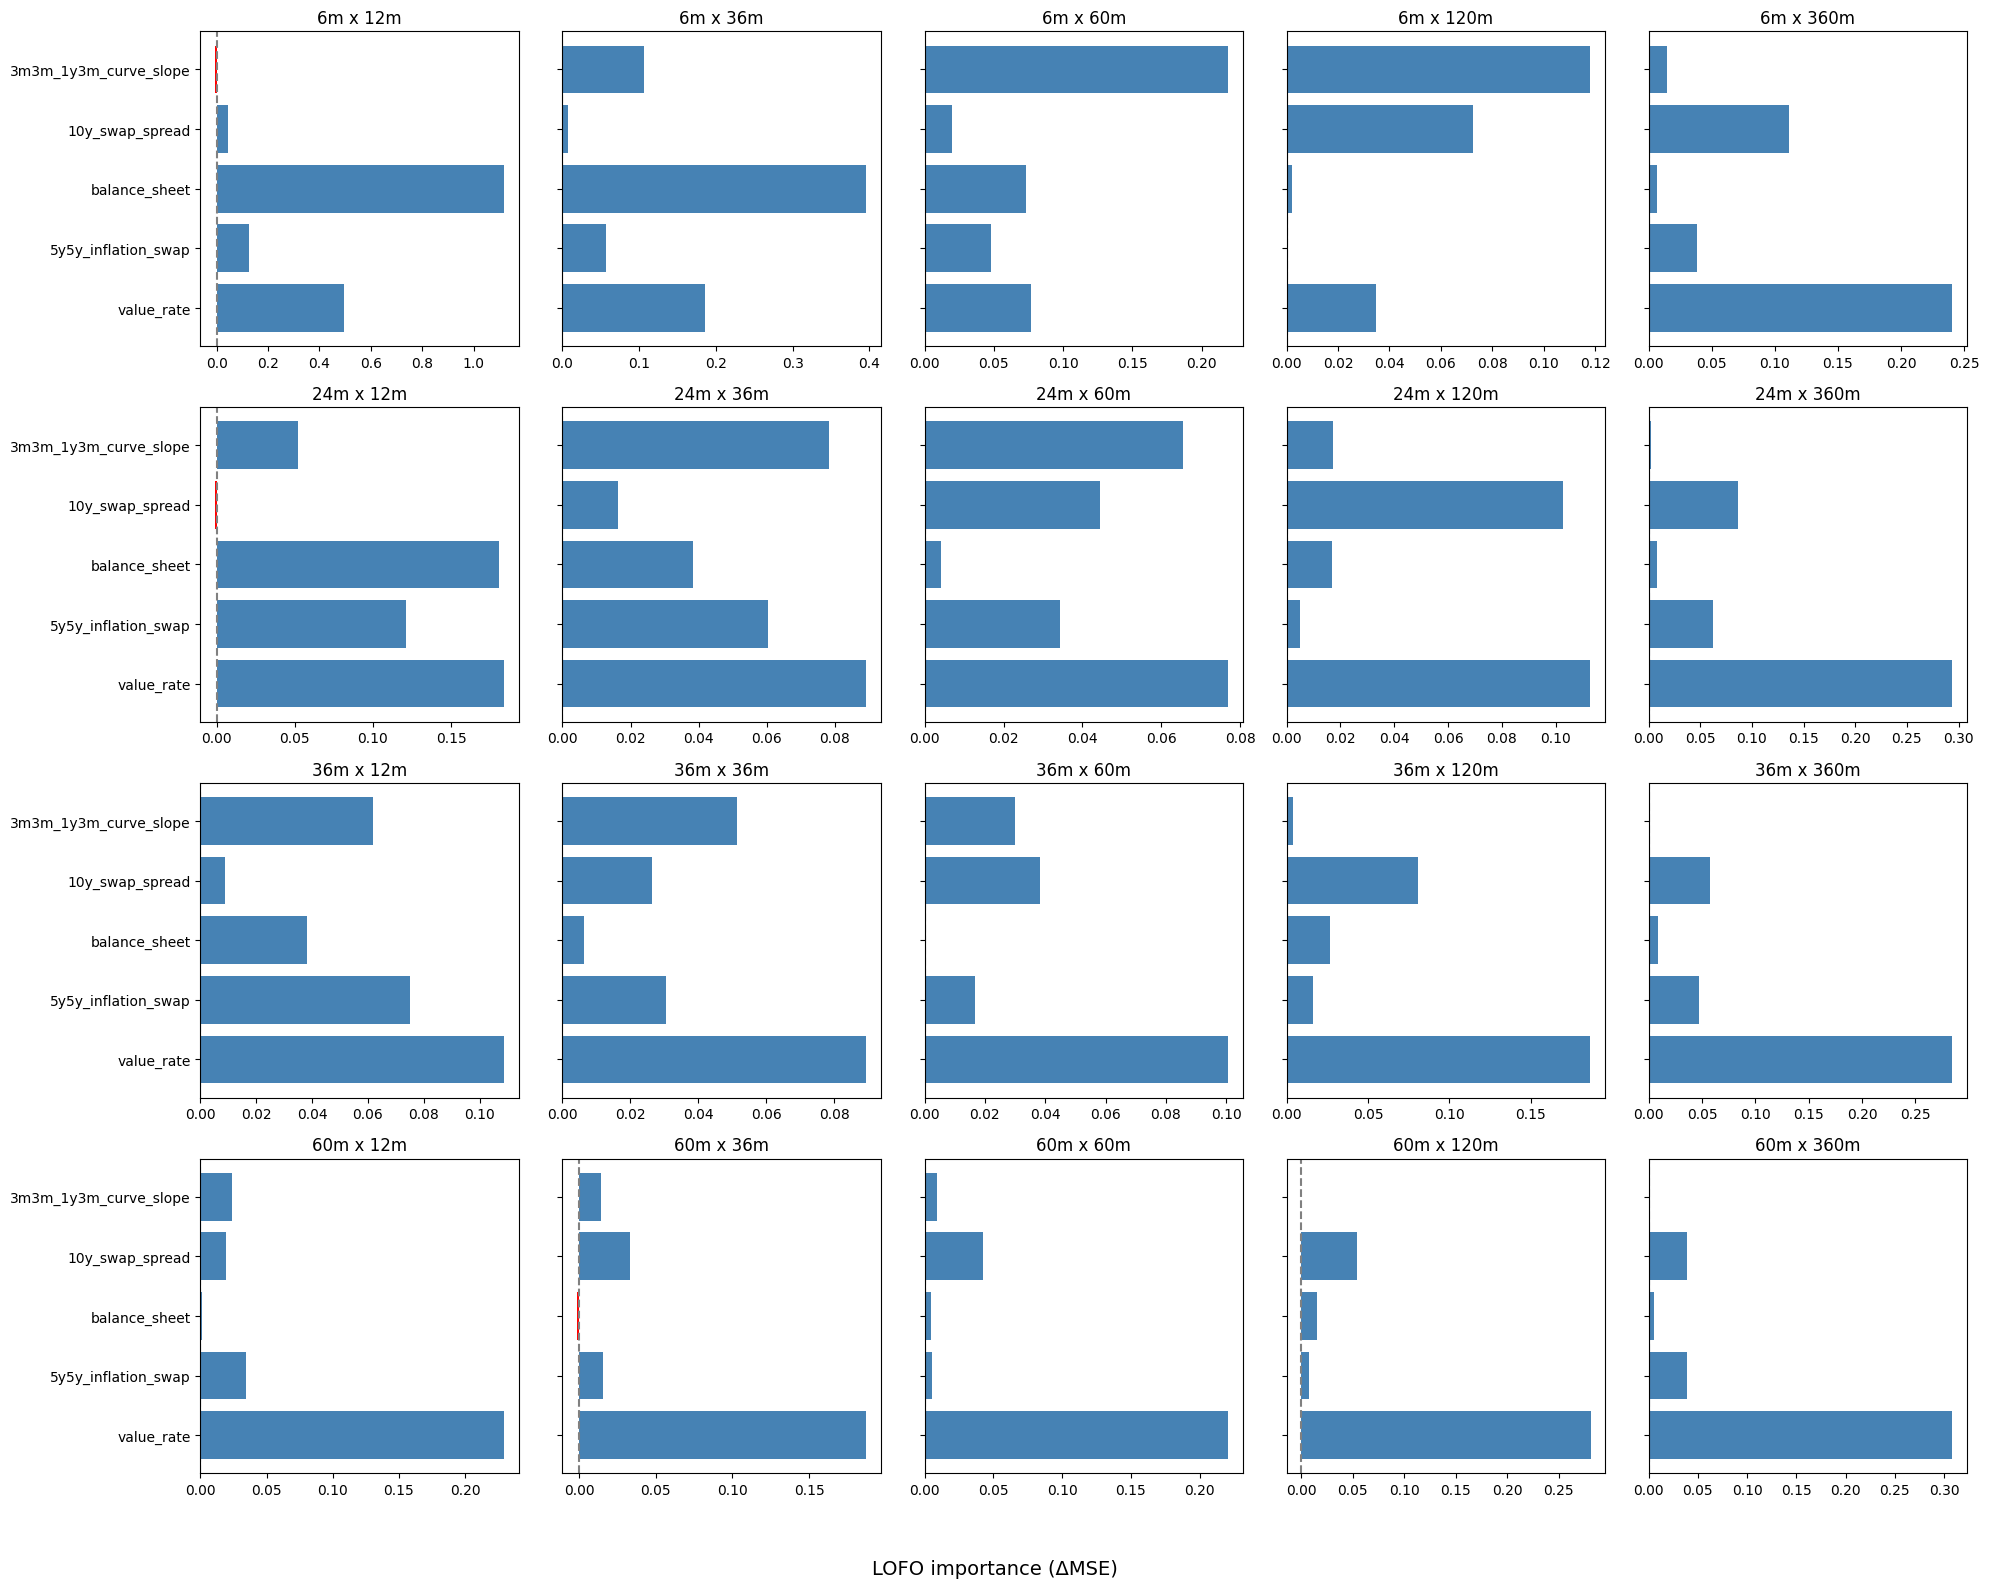

In [24]:
# Keep your imports and data prep as-is
macro_features = ['value_rate', '5y5y_inflation_swap', 'balance_sheet', '10y_swap_spread', '3m3m_1y3m_curve_slope']

# Get all unique (start_months, tenor_months) pairs and filter:
# - remove 3m and 12m expiries
# - remove 24m tenors and 84m
combinations = (
    eur_regression_df[['start_months', 'tenor_months']]
    .drop_duplicates()
    .sort_values(['start_months', 'tenor_months'])
    .values.tolist()
)
combinations = [(start, tenor) for (start, tenor) in combinations if start not in [3, 12] and tenor not in [24, 84]]

# Layout: 4 rows × 6 columns
ncols = 5
nrows = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharey=True)
axes = axes.flatten()

for idx, (start, tenor) in enumerate(combinations[:nrows*ncols]):
    df_sub = eur_regression_df.query(
        "start_months == @start and tenor_months == @tenor"
    ).dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        axes[idx].set_visible(False)
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 1) Original model error
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    e_orig = mean_squared_error(y_test, y_pred)

    # 2) LOFO for each feature
    lofo_scores = []
    for feature in macro_features:
        X_train_lofo = X_train.drop(columns=[feature])
        X_test_lofo = X_test.drop(columns=[feature])
        model_lofo = LinearRegression().fit(X_train_lofo, y_train)
        y_pred_lofo = model_lofo.predict(X_test_lofo)
        e_lofo = mean_squared_error(y_test, y_pred_lofo)
        lofo_scores.append(e_lofo - e_orig)

    # Color: red if negative, steelblue if positive
    colors = ['red' if v < 0 else 'steelblue' for v in lofo_scores]

    # 3) Plot
    ax = axes[idx]
    y_pos = np.arange(len(macro_features))
    ax.barh(y_pos, lofo_scores, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(macro_features)
    # Remove per-axes x-labels
    # ax.set_xlabel('LOFO importance (ΔMSE)')
    ax.set_title(f'{start}m x {tenor}m')
    ax.axvline(0, color='gray', linestyle='--')
    # Remove any y-axis label that said "Feature"
    ax.set_ylabel('')

# Hide any unused axes
for j in range(len(combinations[:nrows*ncols]), len(axes)):
    axes[j].set_visible(False)

# Remove the overall title (no suptitle)
# Add a single x-axis label for the whole figure
fig.supxlabel('LOFO importance (ΔMSE)', fontsize=14)

# Tidy layout, leaving room for the shared xlabel
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


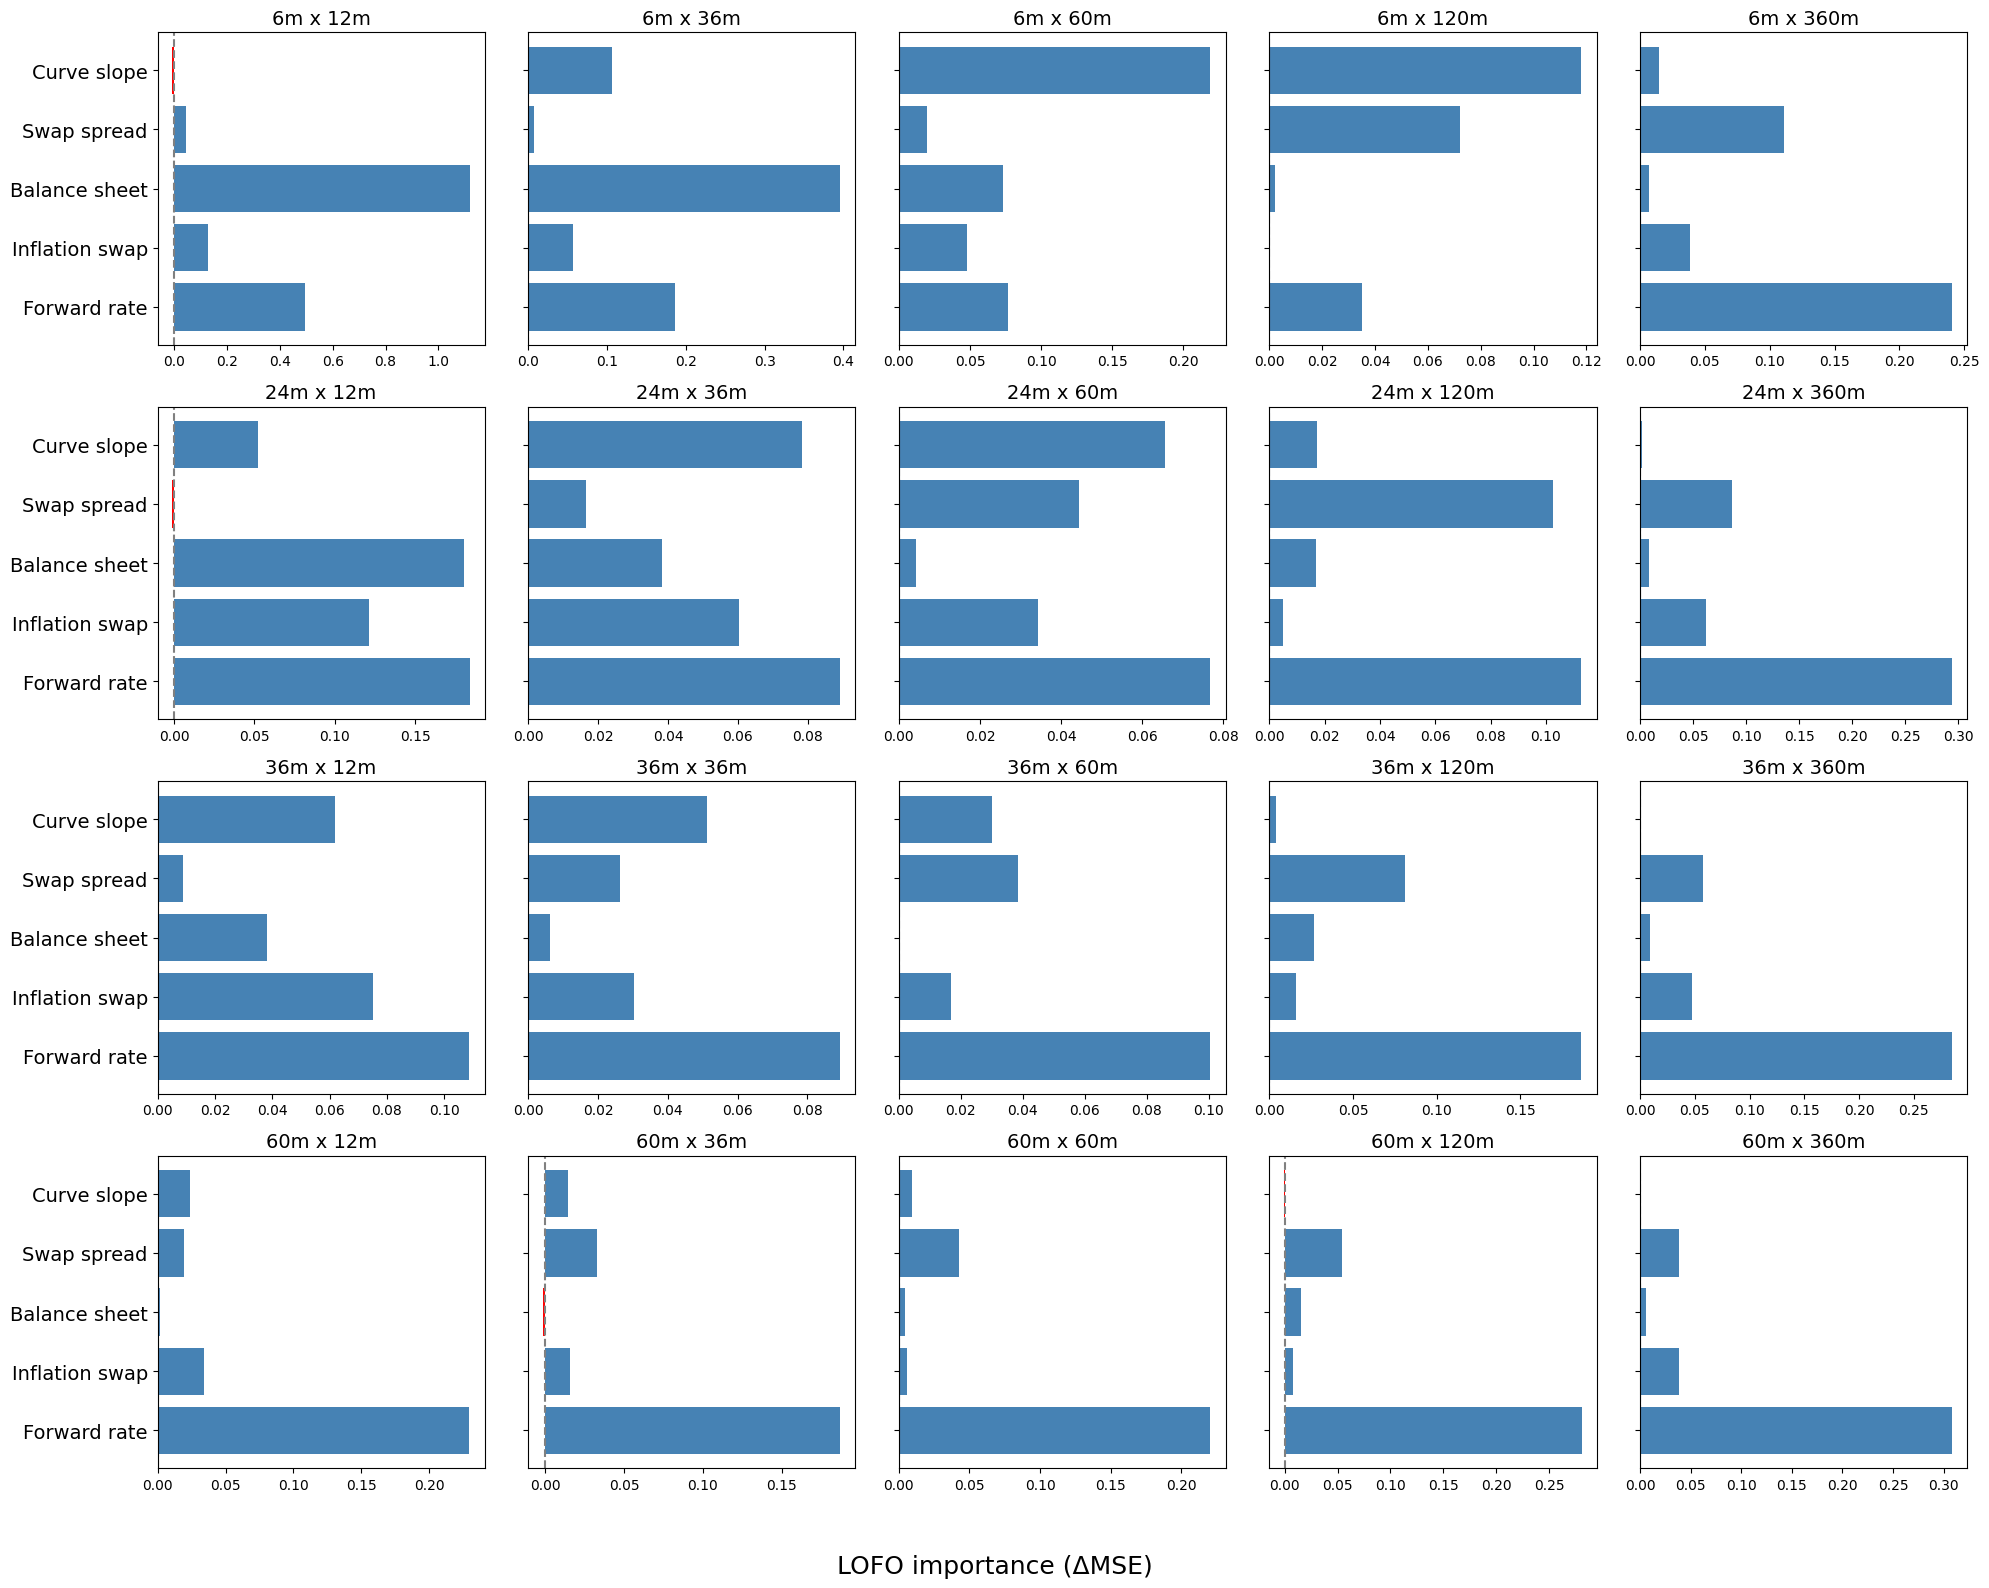

In [25]:
# Pretty labels for plotting
label_map = {
    'value_rate': 'Forward rate',
    '5y5y_inflation_swap': 'Inflation swap',
    'balance_sheet': 'Balance sheet',
    '10y_swap_spread': 'Swap spread',
    '3m3m_1y3m_curve_slope': 'Curve slope'
}

# Keep your imports and data prep as-is
macro_features = list(label_map.keys())

# Get all unique (start_months, tenor_months) pairs and filter:
combinations = (
    eur_regression_df[['start_months', 'tenor_months']]
    .drop_duplicates()
    .sort_values(['start_months', 'tenor_months'])
    .values.tolist()
)
combinations = [(start, tenor) for (start, tenor) in combinations if start not in [3, 12] and tenor not in [24, 84]]

# Layout: 4 rows × 5 columns
ncols = 5
nrows = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharey=True)
axes = axes.flatten()

for idx, (start, tenor) in enumerate(combinations[:nrows*ncols]):
    df_sub = eur_regression_df.query(
        "start_months == @start and tenor_months == @tenor"
    ).dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        axes[idx].set_visible(False)
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 1) Original model error
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    e_orig = mean_squared_error(y_test, y_pred)

    # 2) LOFO for each feature
    lofo_scores = []
    for feature in macro_features:
        X_train_lofo = X_train.drop(columns=[feature])
        X_test_lofo = X_test.drop(columns=[feature])
        model_lofo = LinearRegression().fit(X_train_lofo, y_train)
        y_pred_lofo = model_lofo.predict(X_test_lofo)
        e_lofo = mean_squared_error(y_test, y_pred_lofo)
        lofo_scores.append(e_lofo - e_orig)

    # Colors: red if negative, steelblue if positive
    colors = ['red' if v < 0 else 'steelblue' for v in lofo_scores]

    # 3) Plot
    ax = axes[idx]
    y_pos = np.arange(len(macro_features))
    ax.barh(y_pos, lofo_scores, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([label_map[f] for f in macro_features], fontsize=14)  # use pretty labels
    ax.set_title(f'{start}m x {tenor}m', fontsize=14)
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_ylabel('')

# Hide any unused axes
for j in range(len(combinations[:nrows*ncols]), len(axes)):
    axes[j].set_visible(False)

# Shared x-label for the whole figure
fig.supxlabel('LOFO importance (ΔMSE)', fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()
